In [ ]:
!pip install datasets

In [ ]:
import os
import json
from pathlib import Path
import shutil
from datasets import load_dataset

import warnings
warnings.filterwarnings('ignore')

# import os

# Set the environment variable to use CPU as a fallback
# os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO']='0.0'

In [ ]:
# %%bash
# clone repository
# !git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
103679.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Cloning into 'ICDAR-2019-SROIE'...
remote: Enumerating objects: 2386, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 2386 (delta 18), reused 18 (delta 18), pack-reused 2366
Receiving objects: 100% (2386/2386), 278.64 MiB | 1.95 MiB/s, done.
Resolving deltas: 100% (239/239), done.
Updating files: 100% (1980/1980), done.


In [ ]:
# copy data
# !cp -r ICDAR-2019-SROIE/data ./

In [ ]:
# clean up
# !rm -rf ICDAR-2019-SROIE
# !rm -rf data/box

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip  '/content/drive/MyDrive/Colab Notebooks/Copy_of_data_800_images.zip'

# Converting existing dataset into donut specific format

In [ ]:
import os
import json
from pathlib import Path
import shutil
from pprint import pprint

# define paths: paste path of data folder
base_path = Path("/content/data_800_images/train")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")


# define metadata list
metadata_list = []

# parse metadata
for file_name in metadata_path.glob("*.json"):
  with open(file_name, "r") as json_file:
    # load json file
    data = json.load(json_file)

    # create "text" column with json string
    text = json.dumps(data)
    # add to metadata list if image exists
    if image_path.joinpath(f"{file_name.stem}.jpg").is_file():
      metadata_list.append({"text":text,"file_name":f"{file_name.stem}.jpg"})
      # delete json file

# write jsonline file
with open(image_path.joinpath('metadata.jsonl'), 'w') as outfile:
    for entry in metadata_list:
        # print(entry)
        json.dump(entry, outfile)
        outfile.write('\n')

# remove old meta data
# shutil.rmtree(metadata_path)

In [ ]:
!pip install -q datasets

In [ ]:
import os
import json
from pathlib import Path
import shutil
from datasets import load_dataset

# define paths
base_path = Path("/content/data_800_images/train")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")


# Load dataset
dataset = load_dataset("imagefolder", data_dir=image_path, split="train")
# dataset

print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")

Resolving data files:   0%|          | 0/703 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset has 702 images
Dataset features are: dict_keys(['image', 'text'])


# Now, lets take a closer look at our dataset

Random sample is 378
OCR text is {"invoice_no": "93219493", "invoice_date": "05/16/2019", "vendor_name": "James PLC", "vendor_address": "452 Michelle Branch Aaronberg, UT 13177"}


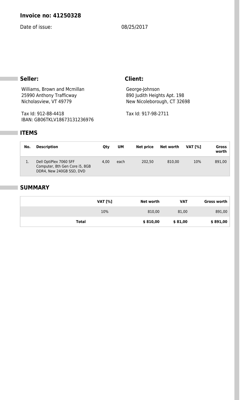

In [ ]:
import random

random_sample = random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")

dataset[random_sample]['image'].resize((250,400))

# Prepare dataset for Donut

In [ ]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}

proc_dataset = dataset.map(preprocess_documents_for_donut)

print(f"Sample: {proc_dataset[45]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")
#    Sample: <s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>
#    New special tokens: ['<s_total>', '</s_total>', '<s_date>', '</s_date>', '<s_company>', '</s_company>', '<s_address>', '</s_address>', '<s>', '</s>']
# The next step is to token

Map:   0%|          | 0/702 [00:00<?, ? examples/s]

## The next step is to tokenize our text and encode the images into tensors. Therefore we need to load DonutProcessor, add our new special tokens and adjust the size of the images when processing from [1920, 2560] to [720, 960] to need less memory and have faster training.

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install -q transformers[sentencepiece]

In [ ]:
from transformers import DonutProcessor

# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [960,1280]
processor.feature_extractor.size = [720,960] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

2023-09-07 10:38:19.622195: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


### Now, we can prepare our dataset, which we will use for the training later.

In [ ]:
def transform_and_tokenize(sample,
                           processor=processor,
                           split="train",
                           max_length=512,
                           ignore_id=-100):

    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt").pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}

    # tokenize document
    input_ids = processor.tokenizer(
                                    sample["text"],
                                    add_special_tokens=False,
                                    max_length=max_length,
                                    padding="max_length",
                                    truncation=True,
                                    return_tensors="pt",)["input_ids"].squeeze(0)

    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token

    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}

# need at least 32-64GB of RAM to run this
processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"])

In [ ]:
processed_dataset = processed_dataset.train_test_split(test_size=0.1)
print(processed_dataset)

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 563
    })
    test: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 63
    })
})


# Fine-tune and evaluate Donut model

In [ ]:
import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig

# Load model from huggingface.co
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
model.config.decoder.max_length = len(max(processed_dataset["train"]["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

# is done by Trainer
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 57525. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


New embedding size: Embedding(57525, 1024, padding_idx=1)


In [ ]:
# is done by Trainer
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

In [ ]:
device

'cpu'

## Before we can start our training we need to define the hyperparameters (Seq2SeqTrainingArguments) we want to use for our training. We are leveraging the Hugging Face Hub integration of the Seq2SeqTrainer to automatically push our checkpoints, logs and metrics during training into a repository.

In [ ]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# hyperparameters used for multiple args
hf_repository_id = "donut-base-sroie"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    # output_dir=hf_repository_id,
    output_dir = './donut_model_notebook',
    num_train_epochs=30,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    weight_decay=0.01,
    # fp16=True,
    fp16 = False,
    logging_steps=50,
    save_total_limit=2,
    evaluation_strategy="no",
    save_strategy="epoch",
    predict_with_generate=True,
    # push to hub parameters
    report_to="tensorboard",
    # push_to_hub=True,
    push_to_hub = False,
    hub_strategy="every_save",
    # hub_model_id=hf_repository_id,
    hub_token=HfFolder.get_token(),
    fp16_full_eval=False,
)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
)

In [ ]:
# model

In [ ]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [ ]:
try:
    trainer.train()
except Exception as e:
    print(e)

Step,Training Loss
50,0.273800
100,0.169000
150,0.133200
200,0.124200


MPS backend out of memory (MPS allocated: 12.78 GB, other allocations: 104.75 GB). Tried to allocate 224.71 MB on private pool.


In [ ]:
# GIVE PATH OF YOUR DRIVE FOLDER
os.makedirs('processor', exist_ok= True)

In [ ]:
processor.save_pretrained('./processor')

In [ ]:
# GIVE THE PATH OF MODEL:
model.save_pretrained("./model")

In [ ]:
!ls

26312.99s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Donut.ipynb          donut_model_notebook processor
Untitled.ipynb       main.py              train.py
data                 model


# Inference: DON'T RUN THIS INFERENCE

In [ ]:
from loguru import logger

In [ ]:
test_sample = processed_dataset["test"][random.randint(1, 50)]

def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    logger.info('line 9')
    # run inference
    outputs = model.generate(
        pixel_values,
        decoder_input_ids=decoder_input_ids,
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(test_sample["target_sequence"])
    return prediction, target


In [ ]:
prediction, target = run_prediction(test_sample)


2023-09-07 18:15:37.937 | INFO     | __main__:run_prediction:9 - line 9


RuntimeError: Input type (torch.FloatTensor) and weight type (MPSFloatType) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")
processor.feature_extractor.to_pil_image(np.array(test_sample["pixel_values"])).resize((350,600))